In [17]:
import numpy as np
import math
from math import pi
from math import cos, sin, tan
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import tflearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# DH Matrix of Robot

In [18]:
dof_n = 3 #number of dof
pose_variables_n = 16 #number of pose variables, e.g. 2 => planar, 3=> 3d pose, 6=> 3d pose + orientation
def robot_fwd_kin(joints):
    #robot parameters
    #l1 = 0.25 #m
    #l3 = 0.15 #m
    #first row 
    dh_11 = cos(joints[0])
    dh_12 = 0
    dh_13 = -1*sin(joints[0])
    dh_14 = -1*sin(joints[0])*joints[2]

    #second row
    dh_21 = sin(joints[0])
    dh_22 = 0
    dh_23 = cos(joints[0])
    dh_24 = cos(joints[0])*joints[2]

    #3rd row
    dh_31 = 0
    dh_32 = -1
    dh_33 = 0
    dh_34 = joints[1]+joints[2]

    #4th row
    dh_41 = 0
    dh_42 = 0
    dh_43 = 0
    dh_44 = 1
    
    return np.array([[dh_11, dh_12, dh_13, dh_14],
                     [dh_21, dh_22, dh_23, dh_24],
                     [dh_31, dh_32, dh_33, dh_34],
                     [dh_41, dh_42, dh_43, dh_44]])



# Data Generation Segment
This segment is used to generate the training and testing data then saving them in a pickle file, if the data is already generated and no edits are introduced, the user can skip this part


In [24]:
#user defined parameters
#data parameters
data_n = 1*(10**5) #size of vectors of data

#robot parametrs

d_max_range = 0.2 #m
d_min_range = 0   #m

theta_max_range = pi  #rad
theta_min_range = 0   #rad

#calculations
#joint variables
joint1 = np.random.uniform(low=theta_min_range, high=theta_max_range, size=(data_n,))
joint2 = np.random.uniform(low=d_min_range, high=d_max_range, size=(data_n,)) 
joint3 = np.random.uniform(low=d_min_range, high=d_max_range, size=(data_n,))


joints = np.array([joint1, joint2, joint3]).T


#pose calculation

p = np.empty((data_n,4,4))
for i in range(len(joints)):
    p_1 = robot_fwd_kin(joints[i])
    p[i] = p_1
    

p = p.reshape(-1,16)



#dumping the data, user must take care of sequence of dumping
with open('robot_set.pickle','wb') as f:
    pickle.dump([p, joints], f)
            #leave first 3 elements reserved, start your changes after them, there are the pose data, then the joints data

print('\ndata saved :)')


data saved :)


# Data Loading Segment

In [25]:
#data retrieval
with open("robot_set.pickle","rb") as f:
	all_data = pickle.load(f)

pose_data, joints_data = all_data[0], all_data[1]

del all_data

data_n = pose_data.shape[0] #update the size of data sets

test_size = int(0.15*data_n)
validate_size = int(0.15*data_n)

test_pose = pose_data[data_n-test_size:]
test_joints = joints_data[data_n-test_size:]

pose_data = np.delete(pose_data, list(range(data_n-test_size , pose_data.shape[0])), axis=0)
joints_data = np.delete(joints_data, list(range(data_n-test_size , joints_data.shape[0])), axis=0)

op_len = joints_data.shape[1]
ip_len = pose_data.shape[1]

# Data preprocessing
# Sequence padding
# pose_data = pad_sequences(pose_data, value=0.)
# test_pose = pad_sequences(test_pose, value=0.)

# reshape input to be [samples, time steps, features]
pose_data = np.reshape(pose_data, (pose_data.shape[0], 1, pose_data.shape[1]))



In [26]:
print(pose_data.shape)
print(pose_data[1])
print(joints_data.shape)

(85000, 1, 16)
[[-0.998915    0.         -0.04657057 -0.00577238  0.04657057  0.         -0.998915
  -0.12381454  0.         -1.          0.          0.30289346  0.          0.
   0.          1.        ]]
(85000, 3)


# Trajectory Data

In [27]:
points_n_t = 20
traj_joint = np.array([np.linspace(0,pi,points_n_t), np.linspace(0,0.2,points_n_t), np.linspace(0,0.2,points_n_t)]).T
p_t = np.empty((len(traj_joint),4,4))
for i in range(len(traj_joint)):
    p_1_t = robot_fwd_kin(traj_joint[i])
    p_t[i] = p_1_t
    
p_t_ip = p_t.reshape(-1,16)
px = p_t[:,0,3]
py = p_t[:,1,3]
pz = p_t[:,2,3]

# Neural Network Definition

In [ ]:
alpha = 0.001  #learning rate, default 0.001
rnn_size = 128
n_nodes = op_len
# Network building
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 16)))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(pose_data, joints_data, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


# Training And Evaluation

In [12]:
#stopping criteria
n_epochs = 10  #number of feed forward and back prop
min_loss = 0.00334

#training parameters
batch_size = 2**7
model = tflearn.DNN(net)

for i in range(10):
    model.fit({'input': pose_data}, {'targets': joints_data}, n_epoch=int(n_epochs/10), 
        validation_set= 0.1,
        snapshot_step = 5000,snapshot_epoch = True,
        batch_size = batch_size, validation_batch_size = None,
        show_metric = True,  run_id='inv_kin', shuffle = None)	#http://tflearn.org/models/dnn/

print('\ntesting :')
print("evaluation: ", model.evaluate(test_pose, test_joints))


joints_pred = model.predict(p_t_ip)
p_pred = np.empty((len(joints_pred),4,4))
for i in range(len(joints_pred)):
    p_1_pred = robot_fwd_kin(joints_pred[i])
    p_pred[i] = p_1_pred

px_pred = p_pred[:,0,3]
py_pred = p_pred[:,1,3]
pz_pred = p_pred[:,2,3]

Exception: Feed dict asks for variable named 'input' but no such variable is known to exist

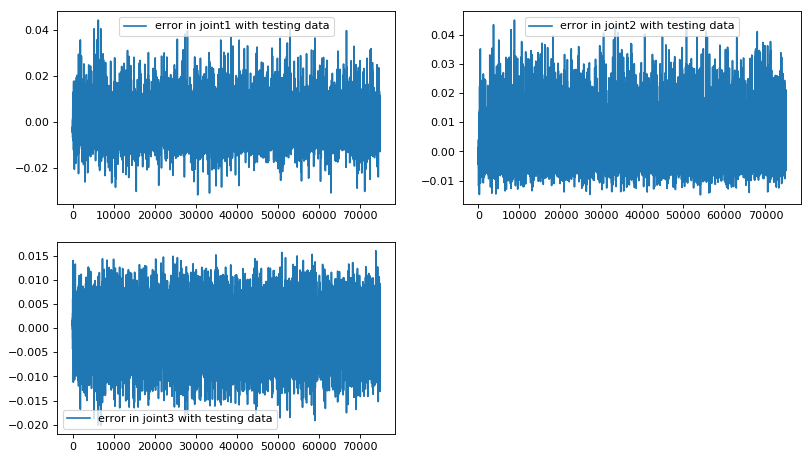

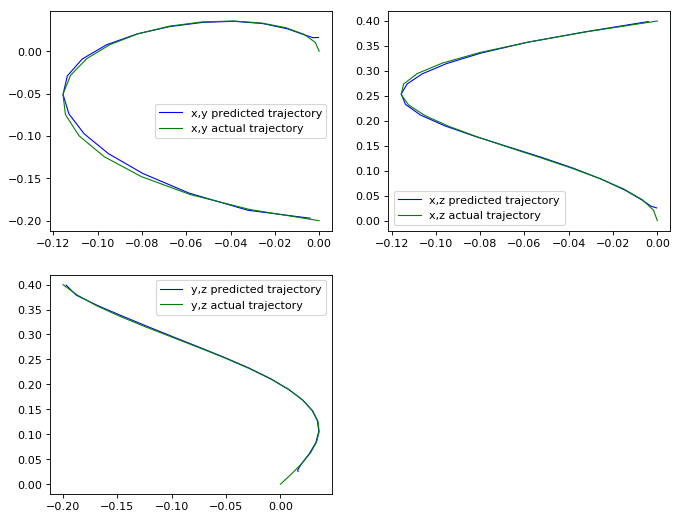

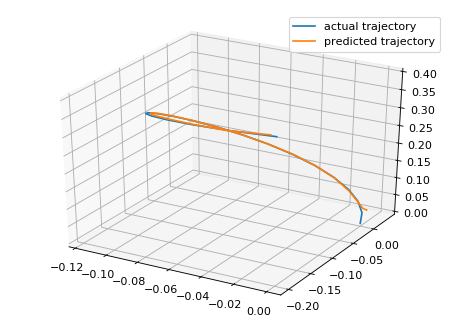

In [14]:
2for i in range(10):
    a=5
print(i)plt.figure(1,figsize=(12,7), dpi=80)
plt.subplot(2,2,1)
plt.plot(actual[:,0]-result[:,0], label='error in joint1 with testing data')
plt.legend()

plt.subplot(2,2,2)
plt.plot(actual[:,1]-result[:,1], label='error in joint2 with testing data')
plt.legend()

plt.subplot(2,2,3)
plt.plot(actual[:,2]-result[:,2], label='error in joint3 with testing data')
plt.legend()

plt.figure(2,figsize=(10,8), dpi=80)

plt.subplot(2,2,1)
plt.plot(px_pred, py_pred, color="blue", linewidth=1.0, linestyle="-", label='x,y predicted trajectory')
plt.plot(px, py, color="green", linewidth=1.0, linestyle="-", label='x,y actual trajectory')
plt.legend()

plt.subplot(2,2,2)
plt.plot(px_pred, pz_pred, color="blue", linewidth=1.0, linestyle="-", label='x,z predicted trajectory')
plt.plot(px, pz, color="green", linewidth=1.0, linestyle="-", label='x,z actual trajectory')
plt.legend()

plt.subplot(2,2,3)
plt.plot(py_pred, pz_pred, color="blue", linewidth=1.0, linestyle="-", label='y,z predicted trajectory')
plt.plot(py, pz, color="green", linewidth=1.0, linestyle="-", label='y,z actual trajectory')
plt.legend()

fig = plt.figure(figsize=(7,5), dpi=80)
ax = fig.gca(projection='3d')
ax.plot(px, py, pz, label='actual trajectory')
ax.plot(px_pred, py_pred, pz_pred, label='predicted trajectory')
ax.legend()

plt.show()

In [15]:
pose_data
q = np.split(pose_data[:10], indices_or_sections=len(pose_data[:10]), axis=0)
print('q=\n',q)

q=
 [array([[  7.48839788e-01,   0.00000000e+00,  -6.62751063e-01,
         -9.36527152e-05,   6.62751063e-01,   0.00000000e+00,
          7.48839788e-01,   1.05817830e-04,   0.00000000e+00,
         -1.00000000e+00,   0.00000000e+00,   1.06424361e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]]), array([[-0.97099289,  0.        , -0.23910838, -0.01870222,  0.23910838,
         0.        , -0.97099289, -0.07594767,  0.        , -1.        ,
         0.        ,  0.11599335,  0.        ,  0.        ,  0.        ,
         1.        ]]), array([[ 0.17426849,  0.        , -0.98469817, -0.02433199,  0.98469817,
         0.        ,  0.17426849,  0.00430619,  0.        , -1.        ,
         0.        ,  0.04405261,  0.        ,  0.        ,  0.        ,
         1.        ]]), array([[-0.5581547 ,  0.        , -0.82973691, -0.13739825,  0.82973691,
         0.        , -0.5581547 , -0.09242626,  0.        , -1.        ,
         0.        ,  0.